<a href="https://colab.research.google.com/github/sakarla/Machine-Learning-for-Architecs/blob/main/week%207_Creating%20a%20training%20data/Code/Week7_Clustring_CSV_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy pandas matplotlib minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=eba01770234552587ea3abbd1eb4178de4f24c684dde42d9e557c39b5f0a4fd6
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [3]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
from minisom import MiniSom
import ast
import matplotlib.pyplot as plt



In [4]:

############################################################################################
image_dir = '/content/drive/MyDrive/Colab Notebooks/downloaded_images'
main_dir = '/content/drive/MyDrive/Colab Notebooks/'
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/image_features_vgg16.csv'
############################################################################################
# Load the CSV file

data = pd.read_csv(csv_file_path)

In [5]:
# Extract filenames and convert stringified lists to actual lists
filenames = data.iloc[:, 0].values
features = data.iloc[:, 1].apply(ast.literal_eval).tolist()
features = np.array(features)

In [6]:
# set parameters for SOM
m = 5
map_size = (m, m)
input_len = features.shape[1]
sigma = 1.0
learning_rate = 0.5
num_epochs = 100

In [7]:
# initialize SOM
som = MiniSom(map_size[0], map_size[1], input_len, sigma=sigma, learning_rate=learning_rate,
              activation_distance='cosine', random_seed=42)
# som.pca_weights_init(features)
som.random_weights_init(features)
# train SOM
som.train_random(features, len(features), verbose=True)
# determine best matching units for each image
bmu_indices = np.array([som.winner(x) for x in features])

 [ 703 / 703 ] 100% - 0:00:00 left 
 quantization error: 606.4661967178909


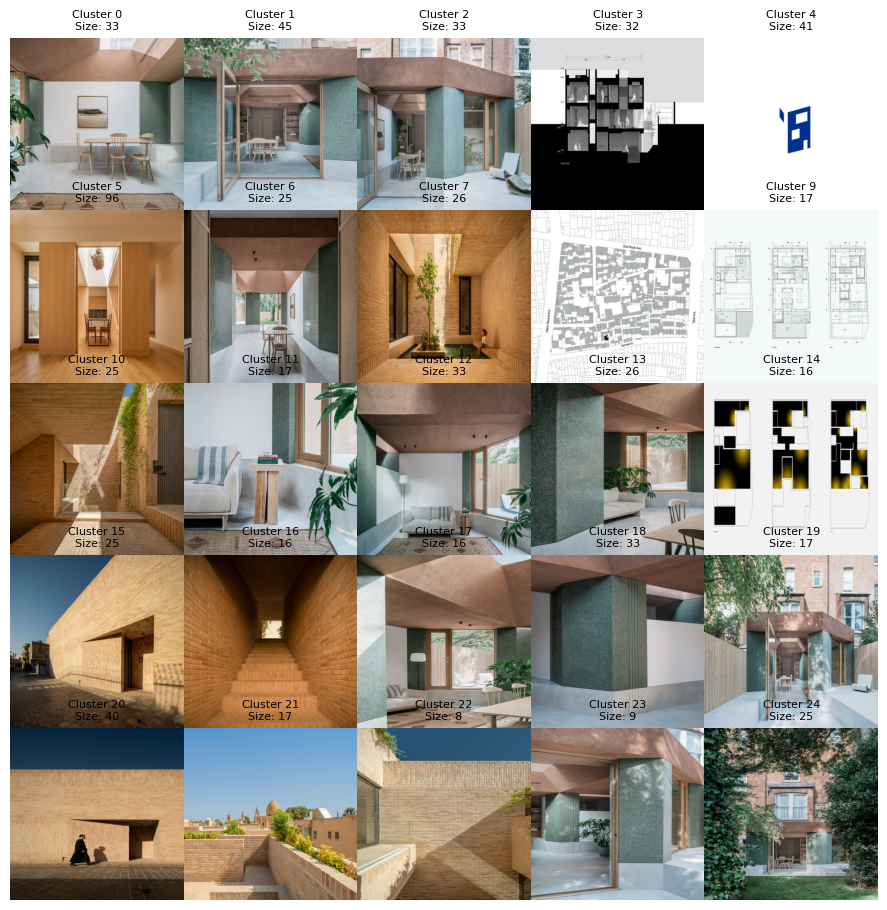

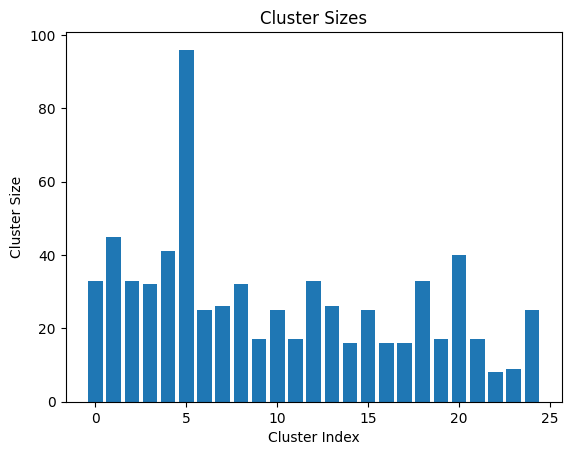

In [8]:

# Define grid size
dpi = 100
subplot_size = 224
figsize = (m * subplot_size / dpi, m * subplot_size / dpi)

# Create a figure with 10x10 subplots
fig, axes = plt.subplots(m, m, figsize=figsize)

# Create a list to keep track of cluster sizes
cluster_sizes = []

# Plot each image in the 10x10 grid
for i in range(m):
    for j in range(m):
        # Get the index of the current SOM node (BMU)
        index = i * m + j

        # Get the list of image indices corresponding to this BMU (i, j)
        bmu_images_indices = [idx for idx, bmu in enumerate(bmu_indices) if tuple(bmu) == (i, j)]

        # Append cluster size to the list
        cluster_sizes.append(len(bmu_images_indices))

        # Plot the first image in the cluster (you can customize this)
        if len(bmu_images_indices) > 0:
            # Load the first image for this BMU
            img_index = bmu_images_indices[0]  # You can loop through all images if needed
            img = Image.open(image_dir + '/' + filenames[img_index])  # Load the image from filename

            # Display the image without black borders and set aspect ratio to 'auto'
            axes[i, j].imshow(img, aspect='auto')
        else:
            # In case of empty clusters, display a placeholder or a message
            axes[i, j].text(0.5, 0.5, "Empty Cluster", ha="center", va="center")

        # Add a title with the cluster index and size
        axes[i, j].set_title(f'Cluster {index}\nSize: {len(bmu_images_indices)}', fontsize=8)

        # Remove the axis ticks for a cleaner look
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        # Hide borders around the images
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['left'].set_visible(False)
        axes[i, j].spines['bottom'].set_visible(False)

# Adjust layout to remove padding between images
plt.subplots_adjust(wspace=0, hspace=0)

# Save the figure to a file
plt.savefig('grid_som_10x10_no_borders.png', bbox_inches='tight', pad_inches=0)

# Visualize cluster sizes as a bar chart
plt.figure()
plt.bar(range(m * m), cluster_sizes)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes')
plt.savefig('cluster_sizes.png')

plt.show()


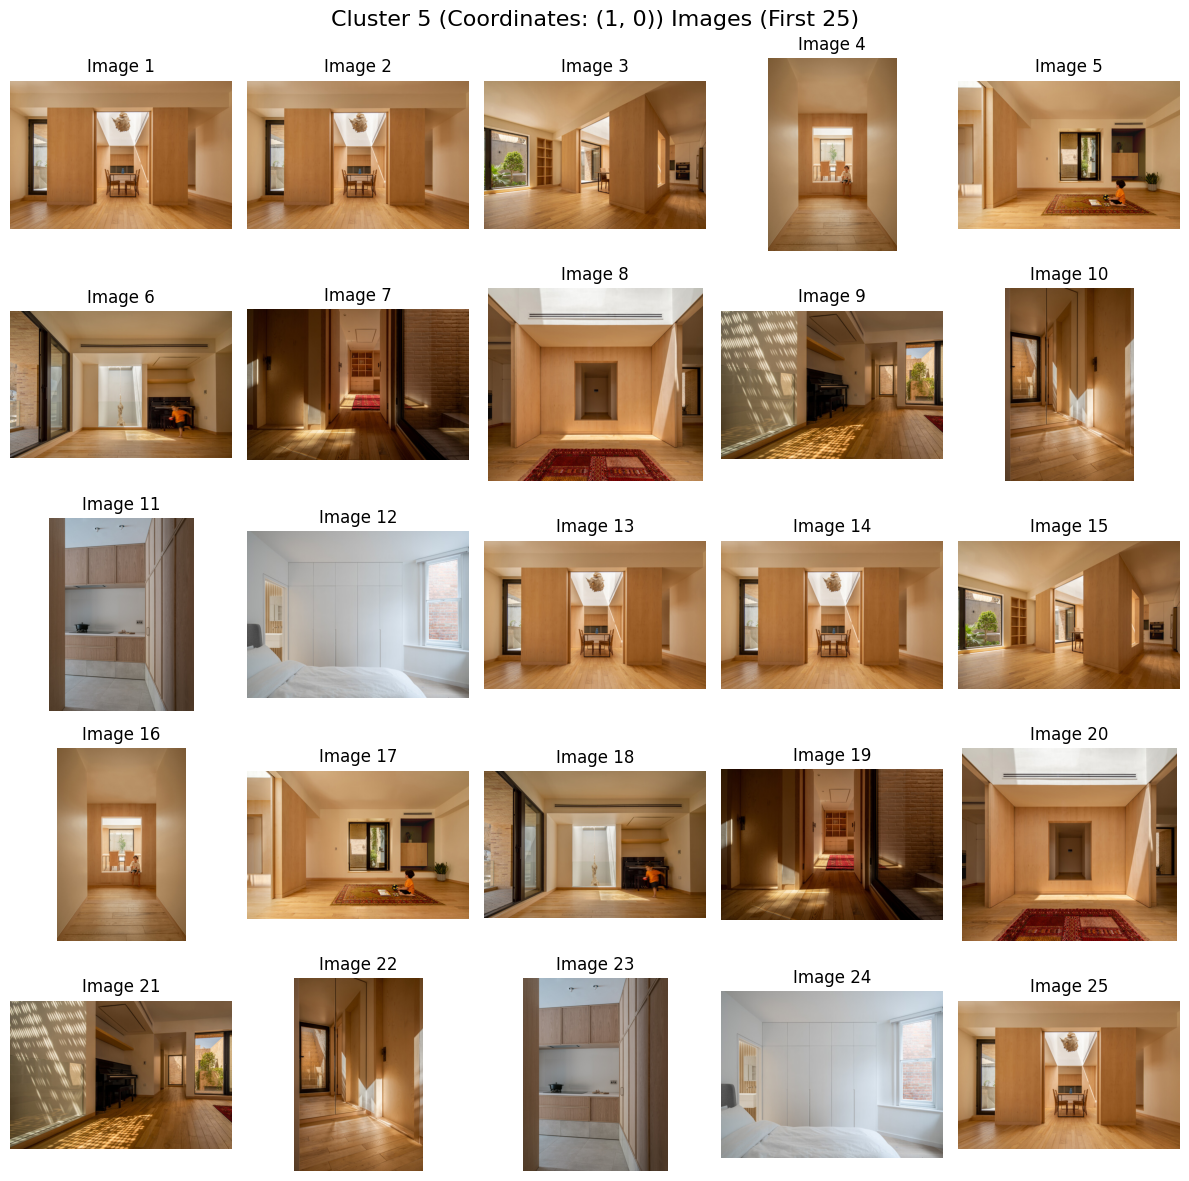

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Set the target cluster number (0 to m*m-1)
target_cluster_number = 5  # Change this to the cluster number you want to display



# Convert the target cluster number to BMU coordinates
target_cluster = (target_cluster_number // m, target_cluster_number % m)  # Convert cluster number to (x, y) coordinates

# Find all image indices belonging to the target cluster
cluster_image_indices = [i for i in range(len(bmu_indices)) if tuple(bmu_indices[i]) == target_cluster]

# Check if there are images in the target cluster
if len(cluster_image_indices) == 0:
    # No images in this cluster, display a message
    plt.figure(figsize=(6, 6))
    plt.text(0.5, 0.5, "There are no images in this cluster", ha="center", va="center", fontsize=16)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()
else:
    # Limit the display to the first 25 images (you can adjust this number)
    num_images_to_display = min(25, len(cluster_image_indices))
    cluster_image_indices = cluster_image_indices[:num_images_to_display]

    # Create a figure to display the cluster images
    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Cluster {target_cluster_number} (Coordinates: {target_cluster}) Images (First {num_images_to_display})", fontsize=16)

    # Iterate through and display the images in a 5x5 grid
    for i, img_index in enumerate(cluster_image_indices):
        plt.subplot(5, 5, i + 1)  # Create a subplot for each image (5 rows x 5 columns)

        try:
            # Load the image from the filename
            img = Image.open(image_dir + '/' + filenames[img_index])
            plt.imshow(img)
            plt.title(f"Image {i+1}")
            plt.axis('off')  # Hide axes for a cleaner display
        except Exception as e:
            print(f"Error loading image {filenames[img_index]}: {e}")
            plt.text(0.5, 0.5, "Error", ha="center", va="center")
            plt.axis('off')

    plt.tight_layout()
    plt.show()


CSV file created: /content/drive/MyDrive/Colab Notebooks/downloaded_images/all_classes_data_som.csv


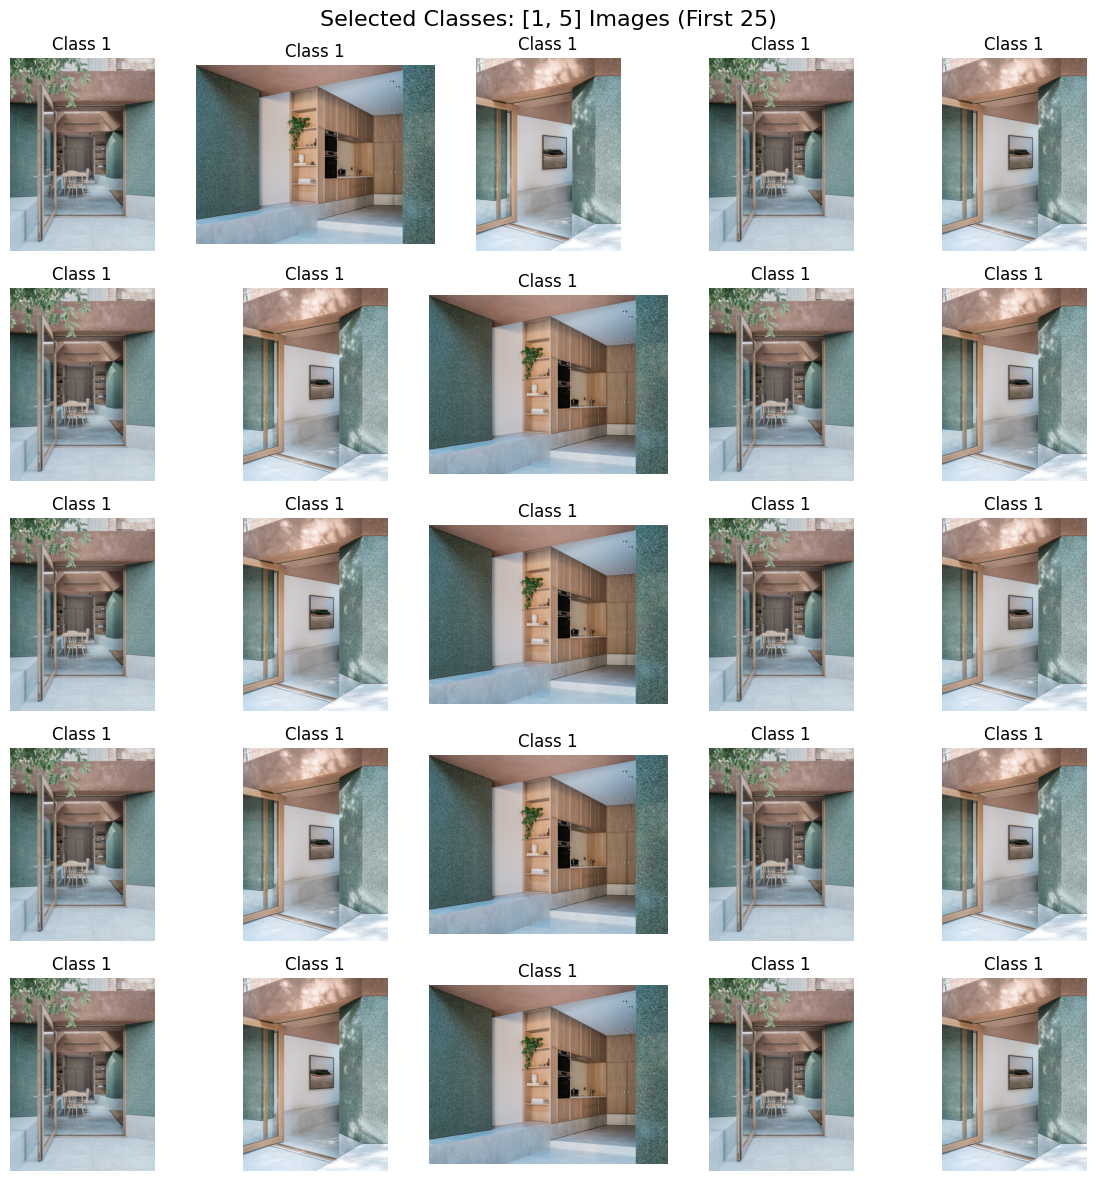

In [17]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming 'image_dir' contains the path to the images, 'filenames' contains the list of image file names,
# 'features' is the array of extracted features, 'bmu_indices' contains the BMU coordinates for each image,
# and 'm' is the dimension of the SOM grid.

# Choose a list of target classes (e.g., [1, 5])
target_classes = [1, 5]  # Modify this list to include the classes you want

# Create a single CSV file to save the data for all classes
csv_filename = 'all_classes_data_som.csv'
csv_filepath = os.path.join(image_dir, csv_filename)

# List to hold images to be displayed (for each target class)
display_images = []

with open(csv_filepath, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Image Name', 'Features', 'Image Path', 'Label'])

    # Loop through each target class and assign all images within that class the same label
    for target_class in target_classes:
        # Find all image indices belonging to the target class by checking BMU indices
        class_image_indices = [i for i in range(len(bmu_indices)) if tuple(bmu_indices[i]) == (target_class // m, target_class % m)]

        # Check if there are images in the current class
        if len(class_image_indices) == 0:
            print(f"There are no images for class: {target_class}.")
            continue

        # Write the data for each image in the selected class and save images to display
        for img_index in class_image_indices:
            image_name = filenames[img_index]
            image_features = features[img_index]
            image_path = os.path.join(image_dir, image_name)
            # Assign the selected target class label to all images
            image_label = target_class  # Label is set as the current target class
            # Write the row: [Image Name, Features, Image Path, Label]
            writer.writerow([image_name, image_features.tolist(), image_path, image_label])
            # Save images for display
            display_images.append((img_index, image_label))

    print(f"CSV file created: {csv_filepath}")

# Display the images in a grid (limit to 25 images for display)
num_images_to_display = min(25, len(display_images))
display_images = display_images[:num_images_to_display]

plt.figure(figsize=(12, 12))
plt.suptitle(f"Selected Classes: {target_classes} Images (First {num_images_to_display})", fontsize=16)

for i, (img_index, img_label) in enumerate(display_images):
    plt.subplot(5, 5, i + 1)  # Create a subplot for each image (5 rows x 5 columns)
    try:
        # Load the image from the filename
        img = Image.open(os.path.join(image_dir, filenames[img_index]))
        plt.imshow(img)
        plt.title(f"Class {img_label}")  # Display the class label as the title
        plt.axis('off')  # Hide axes for a cleaner display
    except Exception as e:
        print(f"Error loading image {filenames[img_index]}: {e}")
        plt.text(0.5, 0.5, "Error", ha="center", va="center")
        plt.axis('off')

plt.tight_layout()
plt.show()